## Heat Equation
Example code for a heat equation integrator, familiarizing ourselves to numpy's fft library with a trivial example problem (completely diagonal in frequency space).

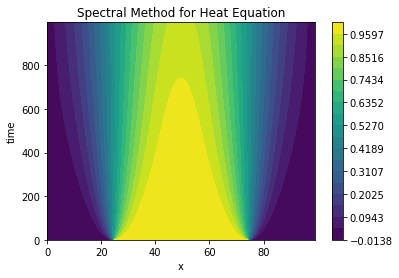

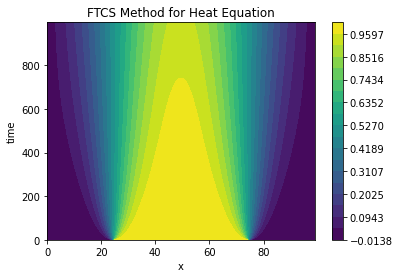

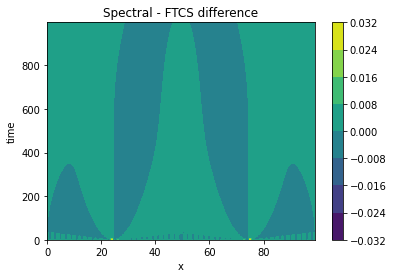

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# simulation parameters
L = 100
T = 10
dt = 0.01

# spectral method in spatial frequency space
def Spectral(u0,t):
    lin   = np.linspace(u0[:,0], u0[:,-1], u0.shape[1], axis=1)     # take out the linear part (set boundaries to 0)
    uhat  = np.fft.rfft(np.concatenate((u0-lin,-(u0-lin)),-1))      # fourier transform of the padded signal (to enforce odd symmetry so boundaries remain 0 through time) 
    freq  = 2 * np.pi * np.fft.rfftfreq(2*L)[np.newaxis,:]          # array of fourier frequencies 
    ts    = np.arange(0,t-dt,dt)[:,np.newaxis]
    uhat *= np.exp(-ts * 1e5 * freq**2/(L*L))                       # soln. to heat equation in frequency space
    return np.fft.irfft(uhat)[:,:L] + lin                           # add back the linear part (not affected by the heat equation)

# finite differences using Euler timestepping
def FTCS(u,t):
    for i in range(int(t//dt) - 1):
        u[i+1][1:-1] = u[i][1:-1] - 1e5*(2 * u[i][1:-1] - u[i][2:] - u[i][:-2]) * dt/(L*L)
    return u

A = np.zeros((int(T//dt),L))
A[:] = np.abs(np.linspace(-2,2,L)) < 1
B = np.zeros((int(T//dt),L))
B[0] = np.abs(np.linspace(-2,2,L)) < 1

A = Spectral(A,T)
B = FTCS(B,T)

levels = np.linspace(np.min(A), np.max(A), 20)

plt.contourf(A, levels, cmap='viridis')
plt.xlabel("x")
plt.ylabel("time")
plt.title("Spectral Method for Heat Equation")
plt.colorbar()
plt.show()

plt.contourf(B, levels, cmap='viridis')
plt.xlabel("x")
plt.ylabel("time")
plt.title("FTCS Method for Heat Equation")
plt.colorbar()
plt.show()

plt.contourf(A-B, cmap='viridis')
plt.xlabel("x")
plt.ylabel("time")
plt.title("Spectral - FTCS difference")
plt.colorbar()
plt.show()

In [73]:
# as we can see, we have pretty good agreement between our methods!
print(f"maximum percent difference: {np.max(A-B)/max(np.max(A), np.max(B)) * 100:.2f}%")
print(f"maximum percent difference after smoothing discontinuous initial condition: {np.max((A-B)[20:])/max(np.max(A), np.max(B)) * 100:.2f}%")

maximum percent difference: 2.90%
maximum percent difference after smoothing discontinuous initial condition: 0.58%


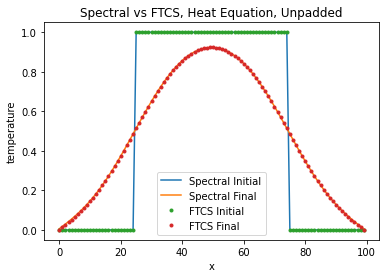

In [74]:
plt.plot(np.fft.irfft(np.fft.rfft(A[0])), label='Spectral Initial')
plt.plot(A[-1], label='Spectral Final')
plt.plot(B[0], '.', label='FTCS Initial')
plt.plot(B[-1], '.', label='FTCS Final')
plt.xlabel("x")
plt.ylabel("temperature")
plt.title("Spectral vs FTCS, Heat Equation, Unpadded")
plt.legend()
plt.show()

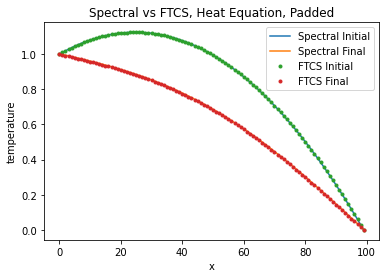

In [75]:
T = 100

def P_fft(u0,t):
    lin  = np.linspace(u0[0], u0[-1], u0.shape[0])
    uhat = np.fft.rfft(np.concatenate(((u0-lin), -(u0-lin))))
    k    = 2 * np.pi * np.fft.rfftfreq(2*L)
    uhat *= np.exp(-t * 1e5 * k**2/(L*L))
    return np.fft.irfft(uhat)[:L] + lin

def P_euler(u,steps):
    for _ in range(steps):
        u[1:-1] += - 1e5*(2 * u[1:-1] - u[2:] - u[:-2]) * dt/(L*L)
    return u

x = np.linspace(0,1,L)
Ai = 1 - x*(2*x-1)
Bi = 1 - x*(2*x-1)

Af = P_fft(Ai,T)
Bf = P_euler(Bi,int(T//dt))

plt.plot(P_fft(Ai,0), label='Spectral Initial')
plt.plot(Af, label='Spectral Final')
plt.plot(Ai, '.', label='FTCS Initial')
plt.plot(Bf, '.', label='FTCS Final')
plt.xlabel("x")
plt.ylabel("temperature")
plt.title("Spectral vs FTCS, Heat Equation, Padded")
plt.legend()
plt.show()

As we can see, taking out the linear part to make the initial condition zero at the boundaries and padding to enforce even symmetry allows us to solve the heat equation for general problems, such as here where an initially parabolic state decays towards a linear ramp between the boundary conditions, as heat would in reality.

## Example of JAX integrators and compilation

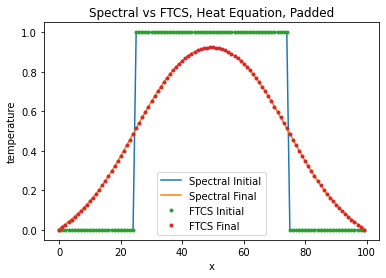

In [76]:
import jax
import jax.numpy as jnp
from jax import jit
from jax.numpy import pi

T = 10

@jit
def P_fft_JAX(u0,t):
    lin  = jnp.linspace(u0[0], u0[-1], u0.shape[0])
    uhat = jnp.fft.rfft(jnp.concatenate((u0-lin, -u0+lin)))
    freq = jnp.fft.rfftfreq(2*L)
    uhat *= jnp.exp(-t * 1e5 * (2*pi * freq)**2/(L*L))
    return jnp.fft.irfft(uhat).at[:L].get() + lin

def finite_step(i,u):
    return u.at[1:-1].add(- 1e5*(2 * u[1:-1] - u[2:] - u[:-2]) * dt/(L*L))

def P_euler_JAX(u,steps):
    return jax.lax.fori_loop(0,steps,finite_step,u)

Ai = jnp.floor(1 - jnp.cos(jnp.linspace(0,2*pi,L)))
Bi = jnp.floor(1 - jnp.cos(jnp.linspace(0,2*pi,L)))

Af = P_fft_JAX(Ai,T)
Bf = P_euler_JAX(Bi,int(T//dt))

plt.plot(P_fft_JAX(Ai,0), label='Spectral Initial')
plt.plot(Af, label='Spectral Final')
plt.plot(Bi, '.', label='FTCS Initial')
plt.plot(Bf, '.', label='FTCS Final')
plt.xlabel("x")
plt.ylabel("temperature")
plt.title("Spectral vs FTCS, Heat Equation, Padded")
plt.legend()
plt.show()

## Example of Newton-Krylov optimization of an integrated state

0:  |F(x)| = 2.55862e-06; step 1
Residual 2.5586249329800914e-06


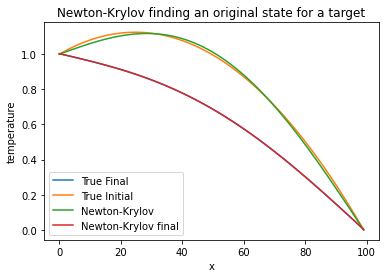

In [85]:
from scipy.optimize import newton_krylov

propagator = P_fft

def Krylov_demo(initial, T):
    target = propagator(initial, T)

    def residual(initial):
        return propagator(initial, T) - target

    guess = target
    sol = newton_krylov(residual, guess, method='lgmres', verbose=1, rdiff=1e-6)
    print('Residual', abs(residual(sol)).max())

    plt.plot(target, label='True Final')
    plt.plot(initial, label='True Initial')
    plt.plot(sol, label='Newton-Krylov')
    plt.plot(P_fft(sol,T), label='Newton-Krylov final')
    plt.xlabel("x")
    plt.ylabel("temperature")
    plt.title("Newton-Krylov finding an original state for a target")
    plt.legend()
    plt.show()

T = 100
initial = 1 - x*(2*x-1)

Krylov_demo(initial, T)

0:  |F(x)| = 1.80805e-05; step 1
1:  |F(x)| = 1.33591e-10; step 1
Residual 1.3359147121860815e-10


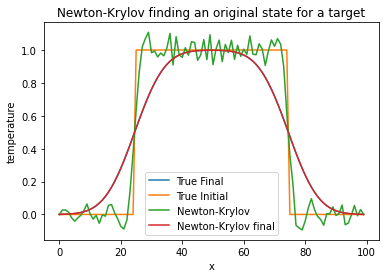

In [86]:
T = 3
initial = np.floor(1 - np.cos(np.linspace(0,2*pi,L)))

Krylov_demo(initial, T)

We construct a target state from an initial state of a square wave, and then we attempt to use scipy's builtin Newton-Krylov solver to regress to the correct initial state. Since the heat equation is the definition of unstable in reverse (it's a forward-time smoothing operator, so in reverse it exponentially amplifies high frequency noise of any kind), we get a large amount of high-frequency noise for the discontinuous square wave solution, but not for the parabolic solution (which shouldn't be surprising).

For some reason, the scipy numerical-differentiation Newton-Krylov routine and the JAX integrators don't play well together (they don't converge). Hopefully this will not be an issue when using automatic differentiation instead, but we shall use both a custom JAX gmres code and Newton-Krylov for the numpy integrator, and compare our results. The advantage of JAX is having no approximation error from numerical differentiation, allowing us to generate full-precision derivatives (32 or 64 bit) for an ~2-4x overhead during computation, whereas here, the numerical differentiation method limits precision to approximately half precision.